* label 재분류
* score 재분류

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



## 한국어 자연어 처리 konlpy와 형태소 분석기 MeCab 설치

In [ ]:
!install g++ openjdk-8-jdk
!pip3 install konlpy JPype1-py3
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

!pip install mecab-python

In [3]:
import re
import urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

from konlpy.tag import Mecab
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

<ipython-input-3-55b0d46d43fd>:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


## 데이터 로드

In [4]:
# train_data = pd.read_csv('/content/drive/MyDrive/Documents/컴공 졸업작품/2학기/각종자료/Dataset/trainingDataset_F.csv')
# test_data = pd.read_csv('/content/drive/MyDrive/Documents/컴공 졸업작품/2학기/각종자료/Dataset/testDataset_F.csv')

train_data = pd.read_csv('/content/drive/MyDrive/trainingDataset_FProcessing.csv')
test_data = pd.read_csv('/content/drive/MyDrive/testDataset_F.csv')

train_data[:10]
# test_data[:10]

,Sentiment_L,Sentiment_S,Text
0,기쁨,신이 난,아내가 드디어 출산하게 되어서 정말 신이 나.
1,불안,스트레스 받는,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야.
2,당황,당황,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워.
3,기쁨,신이 난,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야. 너무 행복해.
4,기쁨,안도,빚을 드디어 다 갚게 되어서 이제야 안도감이 들어.
5,불안,취약한,이제 곧 은퇴할 시기가 되었어. 내가 먼저 은퇴를 하고 육 개월 후에 남편도 은퇴를...
6,슬픔,우울한,사십 대에 접어들면서 머리카락이 많이 빠져 고민이야.
7,분노,구역질 나는,이제 돈이라면 지긋지긋해.
8,분노,좌절한,친구들이 나를 괴롭혀. 부모님과 선생님께 얘기했는데도 믿어주지 않아.
9,슬픔,눈물이 나는,친구 때문에 눈물 나.


## 중복 및 결측치 처리
1. 원본 / 중복 데이터 개수 확인
2. 중복 조회 및 처리
3. 결측치 처리


In [5]:
train_data.count()

,0
Sentiment_L,40771
Sentiment_S,40771
Text,40771


In [6]:
print(train_data['Sentiment_L'].nunique()) # 감정 대분류
print(train_data['Sentiment_S'].nunique()) # 감정 소분류
print(train_data['Text'].nunique()) # 텍스트

6
58
39314


In [7]:
duplicateRow = train_data[train_data.duplicated('Text')]
duplicateRow['Text'].sort_values()

,Text
39203,가끔 회사에서 내가 존재감이 없는 것 같아 외로웠어.
34177,가난한 우리 집 형편에 합의금을 받고서 오히려 가해자 가족에게 고맙다고 했어.
21760,가는 곳마다 금연구역이라 흡연자들이 담배 필 곳이 없어 스트레스받아.
32868,가뜩이나 불면증이 있는데 위층에 사람이 이사 온 후 소음이 심해 진절머리가 나.
40133,가장 믿던 팀원마저 일을 해오지 않았어. 너무 배신감이 들어.
...,...
25305,회의 시간 때 내가 한 말실수로 분위기가 싸해져서 창피했어.
28502,회의 시간에 나의 직급이 낮아서 그런지 의견을 무시하는 경향이 있어서 의견을 제시하...
20227,회의에서 아무도 내 의견을 들어주지 않아. 외톨이가 된 기분이야.
33413,후배들에게 밀린다는 생각을 계속하다 보니 감정이 마비된 느낌이야.


In [8]:
train_data.drop_duplicates(subset=['Text'], inplace=True)
train_data.count() # 중복 처리 확인

,0
Sentiment_L,39314
Sentiment_S,39314
Text,39314


In [9]:
print(train_data.isnull().sum())

train_data = train_data.dropna(how='any')

Sentiment_L    0
Sentiment_S    0
Text           0
dtype: int64


## 데이터 정제
한글과 공백을 제외하고 모두 제거

In [26]:
train_data['Text'] = train_data['Text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", regex=True)
train_data[:10]

,Sentiment_L,Sentiment_S,Text,label
0,기쁨,신이 난,아내가 드디어 출산하게 되어서 정말 신이 나,1.0
1,불안,스트레스 받는,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야,0.0
2,당황,당황,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워,0.5
3,기쁨,신이 난,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야 너무 행복해,1.0
4,기쁨,안도,빚을 드디어 다 갚게 되어서 이제야 안도감이 들어,1.0
5,불안,취약한,이제 곧 은퇴할 시기가 되었어 내가 먼저 은퇴를 하고 육 개월 후에 남편도 은퇴를 ...,0.0
6,슬픔,우울한,사십 대에 접어들면서 머리카락이 많이 빠져 고민이야,0.0
7,분노,구역질 나는,이제 돈이라면 지긋지긋해,0.0
8,분노,좌절한,친구들이 나를 괴롭혀 부모님과 선생님께 얘기했는데도 믿어주지 않아,0.0
9,슬픔,눈물이 나는,친구 때문에 눈물 나,0.0


In [27]:
train_data['label'] = np.where(train_data.Sentiment_L =="기쁨", 1,
         (np.where((train_data.Sentiment_L == "당황") |
                   (train_data.Sentiment_S == "걱정스러운") |
                   (train_data.Sentiment_S == "고립된") |
                   (train_data.Sentiment_S == "조심스러운"),
                   0.5, 0)))
test_data['label'] = np.where(test_data.Sentiment_L =="기쁨", 1,
         (np.where((test_data.Sentiment_L == "당황") |
                   (test_data.Sentiment_S == "걱정스러운") |
                   (test_data.Sentiment_S == "고립된") |
                   (test_data.Sentiment_S == "조심스러운"),
                   0.5, 0)))

train_data[:10]
#test_data[:10]

,Sentiment_L,Sentiment_S,Text,label
0,기쁨,신이 난,아내가 드디어 출산하게 되어서 정말 신이 나,1.0
1,불안,스트레스 받는,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야,0.0
2,당황,당황,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워,0.5
3,기쁨,신이 난,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야 너무 행복해,1.0
4,기쁨,안도,빚을 드디어 다 갚게 되어서 이제야 안도감이 들어,1.0
5,불안,취약한,이제 곧 은퇴할 시기가 되었어 내가 먼저 은퇴를 하고 육 개월 후에 남편도 은퇴를 ...,0.0
6,슬픔,우울한,사십 대에 접어들면서 머리카락이 많이 빠져 고민이야,0.0
7,분노,구역질 나는,이제 돈이라면 지긋지긋해,0.0
8,분노,좌절한,친구들이 나를 괴롭혀 부모님과 선생님께 얘기했는데도 믿어주지 않아,0.0
9,슬픔,눈물이 나는,친구 때문에 눈물 나,0.0


In [28]:
train_data['Text'].replace('', np.nan, inplace=True)
print(len(train_data))
print(train_data.isnull().sum())

39314
Sentiment_L    0
Sentiment_S    0
Text           0
label          0
dtype: int64


<ipython-input-28-62d0b64076af>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['Text'].replace('', np.nan, inplace=True)


In [29]:
train_data = train_data.dropna(how="any")
print(len(train_data))

39314


## 레이블의 분포 확인

<Axes: xlabel='label'>

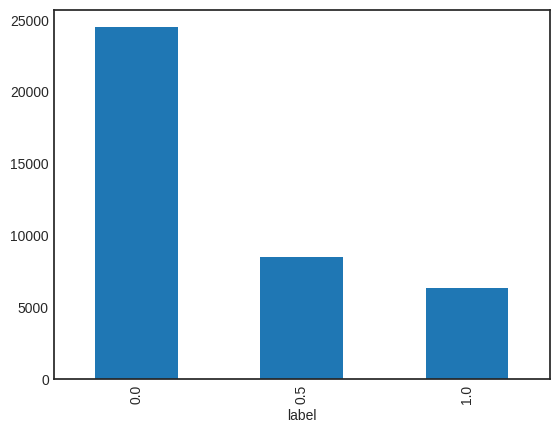

In [30]:
train_data['label'].value_counts().plot(kind = 'bar')

In [31]:
test_data.drop_duplicates(subset=['Text'], inplace=True)
test_data['Text'] = test_data['Text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "")
test_data['Text'].replace('', np.nan, inplace=True)
test_data = test_data.dropna(how='any')
# test_data[:10]

<ipython-input-31-aaabf862d588>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_data['Text'].replace('', np.nan, inplace=True)


## 토큰화 및 불용어 제거

불용어: ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다','하','게','되','어서','때문','니까','어야','랑','야']

In [16]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다','하','게','되','어서','때문','니까','어야','랑','야']

In [32]:
mecab = Mecab()

X_train = []
for sentence in train_data['Text']:
  X_train.append([word for word in mecab.morphs(sentence) if not word in stopwords])

In [33]:
print(X_train[:2])

[['아내', '드디어', '출산', '정말', '신', '나'], ['당뇨', '합병증', '먹', '할', '약', '열', '가지', '넘어가', '스트레스']]


In [34]:
X_test = []
for sentence in test_data['Text']:
  X_test.append([word for word in mecab.morphs(sentence) if not word in stopwords])

## 빈도 수가 낮은 단어 제거
*   빈도 수가 낮은 단어는 학습에 별로 영향을 주지 않음
*   처리를 통해 빈도 수가 낮은 단어들은 제거

In [35]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
print(tokenizer.word_index)

{'어': 1, '을': 2, '나': 3, '고': 4, '는데': 5, '내': 6, '너무': 7, '친구': 8, '아': 9, '해': 10, '있': 11, '했': 12, '지': 13, '것': 14, '같': 15, '에서': 16, '없': 17, '안': 18, '었': 19, '좋': 20, '않': 21, '해서': 22, '일': 23, '만': 24, '네': 25, '받': 26, '다': 27, '았': 28, '사람': 29, '에게': 30, '보': 31, '회사': 32, '아서': 33, '오늘': 34, '요즘': 35, '기': 36, '로': 37, '말': 38, '님': 39, '겠': 40, '던': 41, '돈': 42, '정말': 43, '할': 44, '면': 45, '다고': 46, '걱정': 47, '거': 48, '못': 49, '싶': 50, '스러워': 51, '주': 52, '아내': 53, '수': 54, '건강': 55, '한테': 56, '남편': 57, '생각': 58, '이번': 59, '우리': 60, '힘들': 61, '니': 62, '결혼': 63, '때': 64, '서': 65, '라고': 66, '많이': 67, '집': 68, '직장': 69, '기분': 70, '마음': 71, '돼': 72, '아들': 73, '학교': 74, '많': 75, '적': 76, '모르': 77, '해야': 78, '준비': 79, '봐': 80, '엄마': 81, '당황': 82, '먹': 83, '불안': 84, '남자': 85, '나이': 86, '화가': 87, '살': 88, '슬퍼': 89, '데': 90, '짜증': 91, '이제': 92, '자식': 93, '부모': 94, '자꾸': 95, '가족': 96, '취업': 97, '더': 98, '알': 99, '인데': 100, '난': 101, '아이': 102, '걸': 103, '대': 104, '날': 105, '다는': 

In [36]:
threshold = 3
words_cnt = len(tokenizer.word_index)
rare_cnt = 0
words_freq = 0
rare_freq = 0

for key, value in tokenizer.word_counts.items():
  words_freq = words_freq + value

  if value < threshold:
    rare_cnt += 1
    rare_freq = rare_freq + value

print("전체 단어 수: ", words_cnt)
print("빈도가 {} 이하인 희귀 단어 수: {}".format(threshold-1, rare_cnt))
print("희귀 단어 비율: {}".format((rare_cnt / words_cnt)*100))
print("희귀 단어 등장 빈도 비율: {}".format((rare_freq / words_freq)*100))

전체 단어 수:  12484
빈도가 2 이하인 희귀 단어 수: 6270
희귀 단어 비율: 50.224287087471964
희귀 단어 등장 빈도 비율: 1.5978975965490934


In [37]:
vocab_size = words_cnt-rare_cnt+2
print(vocab_size)

6216


In [38]:
tokenizer = Tokenizer(vocab_size, oov_token='OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [39]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [43]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

X_train = np.array(X_train, dtype=object)
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)

print(len(X_train))
print(len(y_train))

39314
39314


## 패딩

In [44]:
print('Text 최대 길이: ', max(len(l) for l in X_train))
print('Text 평균 길이: ', sum(map(len, X_train))/len(X_train))

Text 최대 길이:  64
Text 평균 길이:  12.901994200539248


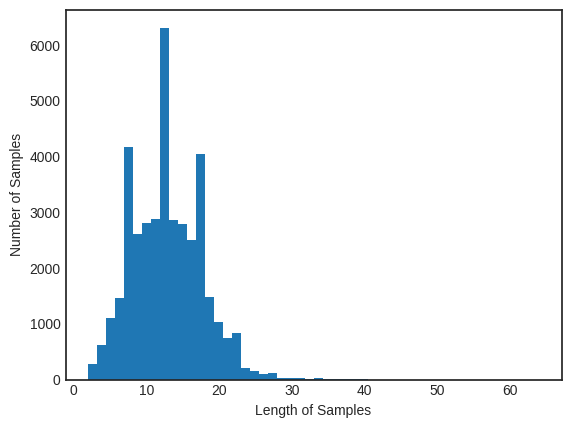

In [45]:
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('Length of Samples')
plt.ylabel('Number of Samples')
plt.show()

In [46]:
max_len = 25

In [47]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

## 모델 학습

In [48]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [49]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(GRU(128))
model.add(Dense(1, activation='relu'))

In [79]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.keras', monitor='val_acc',mode='max', verbose=1,save_best_only=True)

In [80]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy',metrics=['acc'])
history = model.fit(X_train, y_train, epochs=10, callbacks=[es,mc], batch_size=60, validation_split=0.2)

Epoch 1/10
524/525 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.7673 - loss: 0.3149
Epoch 1: val_acc improved from -inf to 0.71843, saving model to best_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - acc: 0.7673 - loss: 0.3149 - val_acc: 0.7184 - val_loss: 0.6749
Epoch 2/10
524/525 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.7684 - loss: 0.3150
Epoch 2: val_acc improved from 0.71843 to 0.72606, saving model to best_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - acc: 0.7684 - loss: 0.3150 - val_acc: 0.7261 - val_loss: 0.6149
Epoch 3/10
524/525 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.7676 - loss: 0.3198
Epoch 3: val_acc did not improve from 0.72606
525/525 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - acc: 0.7676 - loss: 0.3198 - val_acc: 0.7211 - val_loss: 0.5837
Epoch 4/10
517/525 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.7682 - loss: 0.3120
Epoch 4: val_acc did not improve from 0.72606
525/525 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - acc: 0.7682 - loss: 0.3121 - val_acc: 0.7250 - val_loss

In [81]:
loaded_model=load_model('best_model.keras')
loaded_model.evaluate(X_test, y_test)

160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.7102 - loss: 0.6051


[0.5932593941688538, 0.712913990020752]

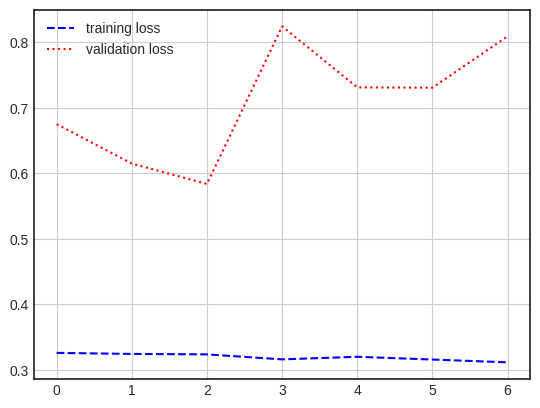

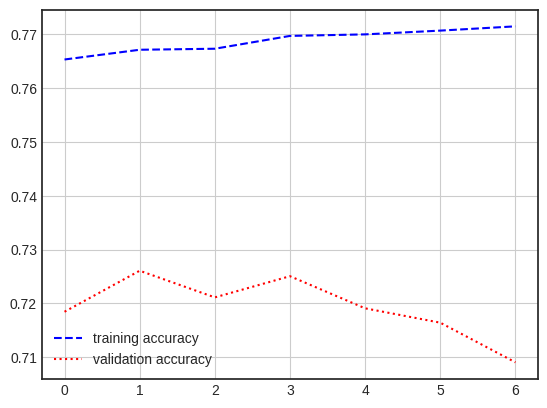

In [83]:
hist_dict = history.history
loss = hist_dict['loss']
val_loss = hist_dict['val_loss']
acc = hist_dict['acc']
val_acc = hist_dict['val_acc']

plt.plot(loss, 'b--', label='training loss')
plt.plot(val_loss, 'r:', label='validation loss')
plt.legend()
plt.grid()

plt.figure()
plt.plot(acc, 'b--', label='training accuracy')
plt.plot(val_acc, 'r:', label='validation accuracy')
plt.legend()
plt.grid()

plt.show()

#감정예측

In [84]:
def sentiment_predict(new_sentence):
  new_token = [word for word in mecab.morphs(new_sentence) if not word in stopwords]
  new_sequences = tokenizer.texts_to_sequences([new_token])
  new_pad = pad_sequences(new_sequences, maxlen = max_len)
  score = float(loaded_model.predict(new_pad))

  if score > 0.7:
    print("{} -> 긍정({:.2f}%)".format(new_sentence, score*100))
  elif score < 0.3:
    print("{} -> 부정({:.2f}%)".format(new_sentence, (1-score)*100))
  else :
    print("{} -> 중립({:.2f}%)".format(new_sentence, (1-score)*100))


In [85]:
sentiment_predict('나는 과일을 좋아해')
sentiment_predict('엄마가 결국 집을 나갔어. 너무 너무 슬퍼.')
sentiment_predict('좋아하는 선배에게 어제 고백을 받았어!')
sentiment_predict('오늘 반장 선거에서 내가 반장이 됐어! 친구들이 날 믿어줘서 너무 고맙다.')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
나는 과일을 좋아해 -> 긍정(70.97%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
엄마가 결국 집을 나갔어. 너무 너무 슬퍼. -> 부정(99.38%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
좋아하는 선배에게 어제 고백을 받았어! -> 긍정(79.75%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
오늘 반장 선거에서 내가 반장이 됐어! 친구들이 날 믿어줘서 너무 고맙다. -> 긍정(107.75%)


<ipython-input-84-45a138c24d2e>:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(loaded_model.predict(new_pad))
